In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold # Para validar

from IPython.display import clear_output # Para ver progreso inline

import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter  # Para formatear los ejes

def ver_dispersion(y_test, prediction, nombre):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, prediction, alpha=0.2)
    plt.title("Dispersión de " + nombre, fontsize=25)
    plt.ylabel("Predicciones", fontsize=20)
    plt.xlabel("Valores reales", fontsize=20)
    plt.xticks(rotation=30, fontsize=17, ha="right")
    plt.yticks(fontsize=17)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    # Recta x = y
    plt.plot([y_test.min(), y_test.max()], [
             y_test.min(), y_test.max()], "k--", lw=4)
    plt.show()
    return None

---
# Carga del train

In [3]:
# 12 columnas
cols1 = ['gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', \
         'centroscomercialescercanos', 'antiguedad', 'habitaciones', \
         'garages', 'banos', 'metroscubiertos', 'metrostotales', 'precio']
train = pd.read_csv('../../data/train_limpio.csv', usecols=cols1)

train['gimnasio'] = train['gimnasio'].astype(np.uint8)
train['usosmultiples'] = train['usosmultiples'].astype(np.uint8)
train['piscina'] = train['piscina'].astype(np.uint8)
train['escuelascercanas'] = train['escuelascercanas'].astype(np.uint8)
train['centroscomercialescercanos'] = train['centroscomercialescercanos'].astype(np.uint8)

train['antiguedad'] = train['antiguedad'].astype(np.uint8)
train['habitaciones'] = train['habitaciones'].astype(np.uint8)
train['garages'] = train['garages'].astype(np.uint8)
train['banos'] = train['banos'].astype(np.uint8)

train['metroscubiertos'] = train['metroscubiertos'].astype(np.uint16)
train['metrostotales'] = train['metrostotales'].astype(np.uint16)

train['precio'] = train['precio'].astype(np.uint32)

In [4]:
# 1 columna
pob = pd.read_csv('../../data/features/ftr_poblacion_train.csv')
train['poblacion'] = pob['pob_ciu'].astype(np.uint32)

In [5]:
# 1 columna
idz = pd.read_csv('../../data/id_zona_V2_train.csv')
train['idzona'] = idz['idzona'].astype(np.uint32)

In [6]:
# 2 columnas
geo = pd.read_csv('../../data/features/ciudad_prov_lat_lng_V2_train.csv', usecols=['lat', 'lng'])

geo['lat'] = geo['lat'].round(8)
geo['lng'] = geo['lng'].round(8)

train = train.join(geo)

In [7]:
# 32 columnas
provincias = pd.read_csv('../../data/features/ftr_provincia_ohe_V2_train.csv')
provincias = provincias.astype(np.uint8)

train = train.join(provincias)

In [8]:
# 11 columnas
ciudades = pd.read_csv('../../data/features/ftr_ciudad_be_V2_train.csv')
ciudades = ciudades.astype(np.uint8)

train = train.join(ciudades)

In [9]:
# 24 columnas
tipodepropiedad = pd.read_csv('../../data/features/ftr_tipo_prop_ohe_V2_train.csv')
tipodepropiedad = tipodepropiedad.astype(np.uint8)

train = train.join(tipodepropiedad)

In [10]:
# 12 columnas
nul = pd.read_csv('../../data/features/is_null_train.csv')
# no se usan las direcciones
nul.drop(columns=['direccion_null'], inplace=True)
nul = nul.astype(np.uint8)

train = train.join(nul)

In [11]:
# 2 columnas
dates = pd.read_csv('../../data/train.csv', usecols=['fecha'], parse_dates=['fecha'])
train['mes'] = dates['fecha'].dt.month.astype(np.uint8)
train['anio'] = dates['fecha'].dt.year.astype(np.uint8)

In [12]:
print('Cantidad de columnas', train.columns.size)
print('Memoria usada', round(train.memory_usage().sum()/(1024*1024), 2), 'MB.')

Cantidad de columnas 97
Memoria usada 27.92 MB.


---
# Extra Trees Regressor
En esta sección solo se prueba con el set de train modificado para entrenar y predecir una sola vez. Más adelante se puede evaluar al predictor a través de un Kfold y según la importancia de sus features.

### División de datos para entrenamiento y objetivo

In [13]:
X = train.drop(columns=['precio'])
y = train['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X_train.shape\t', X_train.shape, '\ty_train.shape\t', y_train.shape)
print('X_test.shape\t', X_test.shape, '\ty_test.shape\t', y_test.shape)

X_train.shape	 (180000, 96) 	y_train.shape	 (180000,)
X_test.shape	 (60000, 96) 	y_test.shape	 (60000,)


### Instanciación de predictor (*random_state=42*)

In [14]:
# n_estimators
num_estimadores = 20
# n_jobs
workers = -1
# Instancia para predictor de Extra Trees
xtr = ExtraTreesRegressor(n_estimators=num_estimadores, n_jobs=workers, random_state=42)

### Entrenamiento 

In [15]:
%%time

#=====================#
# ENTRENAMIENTO ÚNICO #
#=====================#

xtr.fit(X_train, y_train)

CPU times: user 2min 27s, sys: 677 ms, total: 2min 28s
Wall time: 21.6 s


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start=False)

### Predicción del `y_test`

In [16]:
prediction_t = xtr.predict(X_test)
print('Predicción', round(mean_absolute_error(y_test, prediction_t)))

Predicción 573045.0


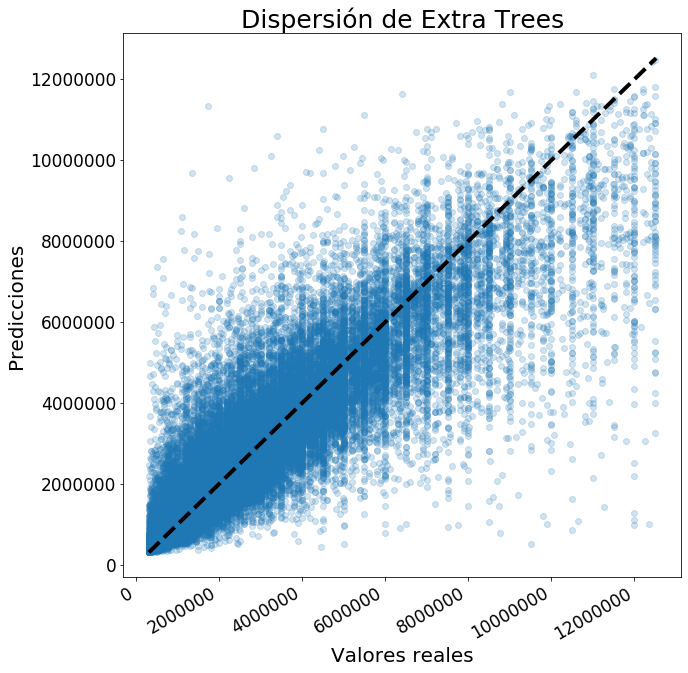

In [17]:
ver_dispersion(y_test, prediction_t, "Extra Trees")

---
# Evaluación del predictor
## Con todas las features cargadas

### División de datos para entrenamiento y objetivo

In [18]:
X = train.drop(columns=['precio'])
y = train['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X_train.shape\t', X_train.shape, '\ty_train.shape\t', y_train.shape)
print('X_test.shape\t', X_test.shape, '\ty_test.shape\t', y_test.shape)

X_train.shape	 (180000, 96) 	y_train.shape	 (180000,)
X_test.shape	 (60000, 96) 	y_test.shape	 (60000,)


### Instanciación de estimador y auxiliares

In [19]:
# n_estimators
num_estimadores = 20
# n_jobs
workers = -1
# Instancia para predictor de Extra Trees
xtr = ExtraTreesRegressor(n_estimators=num_estimadores, n_jobs=workers)

# n_splits
splits = 10
# Instancia para KFold
kf = KFold(n_splits=splits)

# Listas para guardar los puntajes y errores de la evaluación
scores = []
errors = []

### Entrenamiento de folds

In [20]:
%%time
i = 1

for train_index, test_index in kf.split(train) :
    clear_output(wait=True)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print('Entrenando fold', i)
    xtr.fit(X_train, y_train)
    prediction_t = xtr.predict(X_test)
    
    scores.append(xtr.score(X_test, y_test))
    errors.append(mean_absolute_error(y_test, prediction_t))
    i = i + 1

Entrenando fold 10
CPU times: user 31min 37s, sys: 6 s, total: 31min 43s
Wall time: 4min 33s


### Análisis de predictor y predicciones

In [21]:
puntajes = np.array(scores)
errores = np.array(errors)

print('Promedio errores', errores.mean().round(0), \
      '\tcon desvío estándar de', errores.std().round(0))
print('Promedio scores\t', puntajes.mean().round(3), \
      '\t\tcon desvío estándar de',puntajes.std().round(3))

Promedio errores 566341.0 	con desvío estándar de 4895.0
Promedio scores	 0.79 		con desvío estándar de 0.004


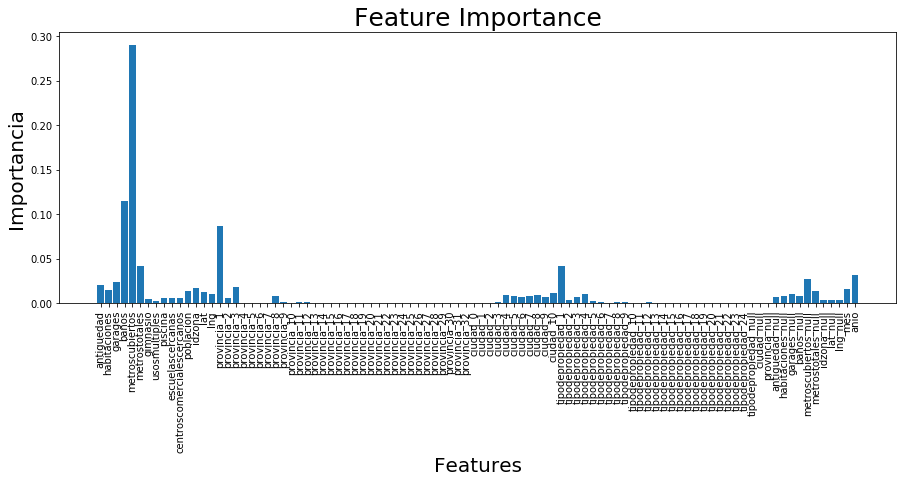

In [22]:
plt.figure(figsize=(15,5))
plt.bar(X_train.columns, xtr.feature_importances_)
plt.xlabel('Features', fontsize=20)
plt.xticks(rotation = 90)
plt.ylabel('Importancia', fontsize=20)
plt.title('Feature Importance', fontsize=25)
plt.show()

---
# Selección de features según importancia
De aquí se obtienen las columnas a droppear según la tolerancia asignada. Conviene ejecutar la celda **ENTRENAMIENTO ÚNICO** para obtener las importancias con todas las features elegidas inicialmente.

In [23]:
%%time

labels_no_out = [] # lista de labels sin outliers.
importances_no_out = [] # lista de importancias sin outliers.
to_drop = [] # lista de columnas a droppear.

#==================#
tolerancia = 1e-3  #
#==================#

i = 1

indice_vector = np.arange(0, xtr.feature_importances_.size)
for var in indice_vector:
    clear_output(wait=True)
    if (xtr.feature_importances_[var] > tolerancia):
        labels_no_out.append(X_train.columns[var])
        importances_no_out.append(xtr.feature_importances_[var])
    else :
        to_drop.append(X_train.columns[var])
    print(i, 'de', indice_vector.size)
    # Aparece una menos porque 'precio' pasó al target
    i = i + 1
    
print('Cantidad de features importantes', len(importances_no_out))
print('Cantidad de features a limpiar', len(to_drop))

96 de 96
Cantidad de features importantes 50
Cantidad de features a limpiar 46
CPU times: user 35.6 s, sys: 448 ms, total: 36.1 s
Wall time: 15.4 s


`ctrl + /` comenta  y descomenta selección 

In [24]:
# Para análisis de predicción según cantidad de estimadores, 
# tomando solamente las columnas importantes.
# Con esto se tienen siempre las mismas columnas.

# to_drop = [
#     'provincia_4', 'provincia_5', 'provincia_6', 'provincia_7', \
#     'provincia_10', 'provincia_13', 'provincia_14', 'provincia_15', \
#     'provincia_16', 'provincia_17', 'provincia_18', 'provincia_19', \
#     'provincia_20', 'provincia_21', 'provincia_22', 'provincia_23', \
#     'provincia_24', 'provincia_25', 'provincia_26', 'provincia_27', \
#     'provincia_28', 'provincia_29', 'provincia_30', 'provincia_31', \
#     'provincia_32', \
#     'ciudad_0', 'ciudad_1', 'ciudad_2' \
#     'tipodepropiedad_7', 'tipodepropiedad_10', 'tipodepropiedad_11', \
#     'tipodepropiedad_13', 'tipodepropiedad_14', 'tipodepropiedad_15', \
#     'tipodepropiedad_16', 'tipodepropiedad_17', 'tipodepropiedad_18', \
#     'tipodepropiedad_19', 'tipodepropiedad_20', 'tipodepropiedad_21', \
#     'tipodepropiedad_22', 'tipodepropiedad_23', 'tipodepropiedad_24', \
#     'tipodepropiedad_null', 'ciudad_null', 'provincia_null'
# ]

---
# Evaluación del predictor
## Features filtradas por importancia

### Se prepara el nuevo set de datos con features importantes

In [25]:
X = train.drop(columns=to_drop)

### División de datos para entrenamiento y objetivo

In [26]:
X = X.drop(columns=['precio'])
y = train['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X_train.shape', X_train.shape, '\ty_train.shape', y_train.shape)
print('X_test.shape', X_test.shape, '\ty_test.shape', y_test.shape)

X_train.shape (180000, 50) 	y_train.shape (180000,)
X_test.shape (60000, 50) 	y_test.shape (60000,)


### Instanciación de estimador y auxiliares

In [27]:
# n_estimators
num_estimadores = 20
# n_jobs
workers = -1
# Instancia para predictor de Extra Trees
xtr = ExtraTreesRegressor(n_estimators=num_estimadores, n_jobs=workers)

# n_splits
splits = 10
# Instancia para KFold
kf = KFold(n_splits=splits)

# Listas para guardar los puntajes y errores de la evaluación
scores = []
errors = []

### Entrenamiento de folds

In [28]:
%%time
i = 1

for train_index, test_index in kf.split(train) :
    clear_output(wait=True)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print('Entrenando fold', i)
    xtr.fit(X_train, y_train)
    prediction_t = xtr.predict(X_test)
    
    scores.append(xtr.score(X_test, y_test))
    errors.append(mean_absolute_error(y_test, prediction_t))
    i = i + 1

Entrenando fold 10
CPU times: user 18min 59s, sys: 4.78 s, total: 19min 4s
Wall time: 2min 45s


### Análisis de predictor y predicciones

In [29]:
puntajes = np.array(scores)
errores = np.array(errors)

print('Promedio errores', errores.mean().round(0), \
      '\tcon desvío estándar de', errores.std().round(0))
print('Promedio scores\t', puntajes.mean().round(3), \
      '\t\tcon desvío estándar de',puntajes.std().round(3))

Promedio errores 568713.0 	con desvío estándar de 4935.0
Promedio scores	 0.79 		con desvío estándar de 0.004


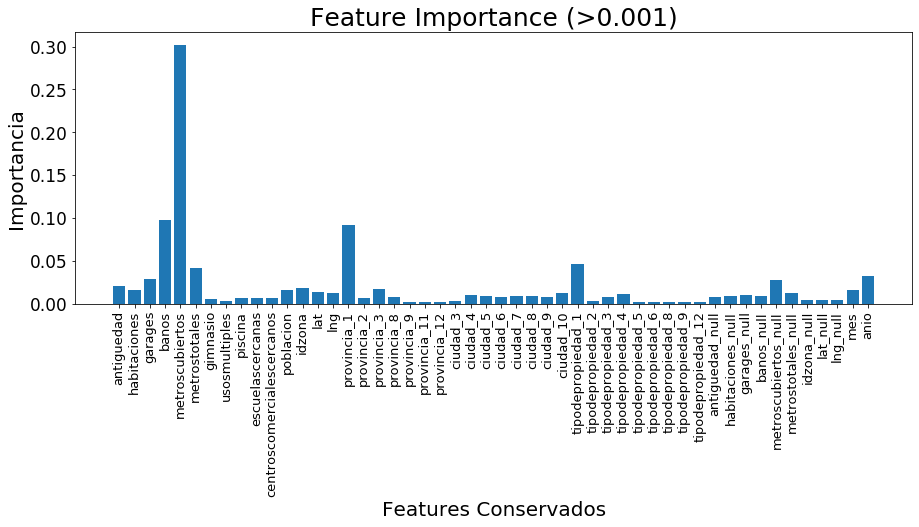

In [30]:
plt.figure(figsize=(15,5))
plt.bar(X_train.columns, xtr.feature_importances_)
plt.xlabel('Features Conservados', fontsize=20)
plt.xticks(rotation = 90, fontsize=13)
plt.ylabel('Importancia', fontsize=20)
plt.yticks(fontsize=17)
plt.title('Feature Importance' + ' (>' + str(tolerancia) + ')', fontsize=25)
plt.show()